<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Plotting-Configs" data-toc-modified-id="Plotting-Configs-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Plotting Configs</a></span></li></ul></li><li><span><a href="#Appendix-B" data-toc-modified-id="Appendix-B-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Appendix B</a></span><ul class="toc-item"><li><span><a href="#Figure-20:-CRLBs-vs.-Sampling" data-toc-modified-id="Figure-20:-CRLBs-vs.-Sampling-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Figure 20: CRLBs vs. Sampling</a></span></li></ul></li><li><span><a href="#Appendix-C" data-toc-modified-id="Appendix-C-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Appendix C</a></span><ul class="toc-item"><li><span><a href="#Figure-21:-DESI-CRLBs" data-toc-modified-id="Figure-21:-DESI-CRLBs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Figure 21: DESI CRLBs</a></span></li></ul></li></ul></div>

## Imports

In [1]:
import pandas as pd
import numpy as np

from chemicalc import instruments as inst
from chemicalc import reference_spectra as ref
from chemicalc.crlb import init_crlb_df, calc_crlb, sort_crlb
from chemicalc.plot import plot_crlb

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D
%matplotlib inline

## Plotting Configs

In [2]:
output_dir = './figures/'

mpl.rc('axes', grid=True, lw=2)
mpl.rc('ytick', direction='in', labelsize=10)
mpl.rc('ytick.major', size=5, width=1)
mpl.rc('xtick', direction='in', labelsize=10)
mpl.rc('xtick.major', size=5, width=1)
mpl.rc('ytick', direction='in', labelsize=10)
mpl.rc('ytick.major', size=5, width=1)
mpl.rc('grid', alpha=0.75, lw=1)
mpl.rc('legend', edgecolor='k', framealpha=1, fancybox=False)
mpl.rc('figure', dpi=300)

# Appendix B

## Figure 20: CRLBs vs. Sampling

In [3]:
# Labels to keep at each S/N
snr_labels = {200: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca', 'Ni', 'Si', 'Ti', 'Co', 'Mg'],
              100: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca', 'Ni', 'Si', 'Ti', 'Co', 'Mg'],
              50: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca', 'Ni', 'Si', 'Ti', 'Co', 'Mg'],
              30: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca', 'Ni', 'Si', 'Ti', 'Co', 'Mg'],
              20: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca', 'Ni', 'Si', 'Ti'],
              15: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca', 'Ni'],
              10: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca'],
              5: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca']}

# Initialize Preset Instrument
allInst = inst.AllInstruments()
d1200g = allInst.get_spectrograph('DEIMOS 1200G')

# Initialize Reference Spectra
RGB = ref.ReferenceSpectra(reference='RGB_m1.5')

# Load NN Spectra
tmp = np.load('NN_spec.npz')
RGB.wavelength[d1200g.name] = tmp['wavelength']
RGB.spectra[d1200g.name] = tmp['spectra']

# Initialize CRLB Data Frames
CRLB_NN = init_crlb_df(RGB)
CRLB_hmc = init_crlb_df(RGB)

# Define Prior
priors = {'Teff': 100, 'logg': 0.15, 'v_micro': 0.25}

# Calculate CRLBs for all S/N
for snr, labels_to_keep in snr_labels.items():
    # Calculate Gradient Spectra
    RGB.calc_gradient(d1200g.name)
    RGB.zero_gradients(d1200g.name, set(RGB.labels.index)^set(labels_to_keep))
    # Set S/N
    d1200g.set_snr(snr)
    # Calculate CRLBs
    CRLB_NN[f'{snr}'] = calc_crlb(RGB, d1200g, priors=priors)
    # Load Precision from Sampling
    samples = pd.read_hdf(f'./hmc_samples/R6500p_snr{snr:03d}_samples.h5')
    CRLB_hmc[f'{snr}'] = samples.std()
    CRLB_hmc[f'{snr}'].loc['Teff'] /= 100

# Sort CRLBs & Pretty Up Indices
CRLB_NN = sort_crlb(CRLB_NN, cutoff=0.3, fancy_labels=True)
CRLB_hmc = sort_crlb(CRLB_hmc, cutoff=0.3, fancy_labels=True)

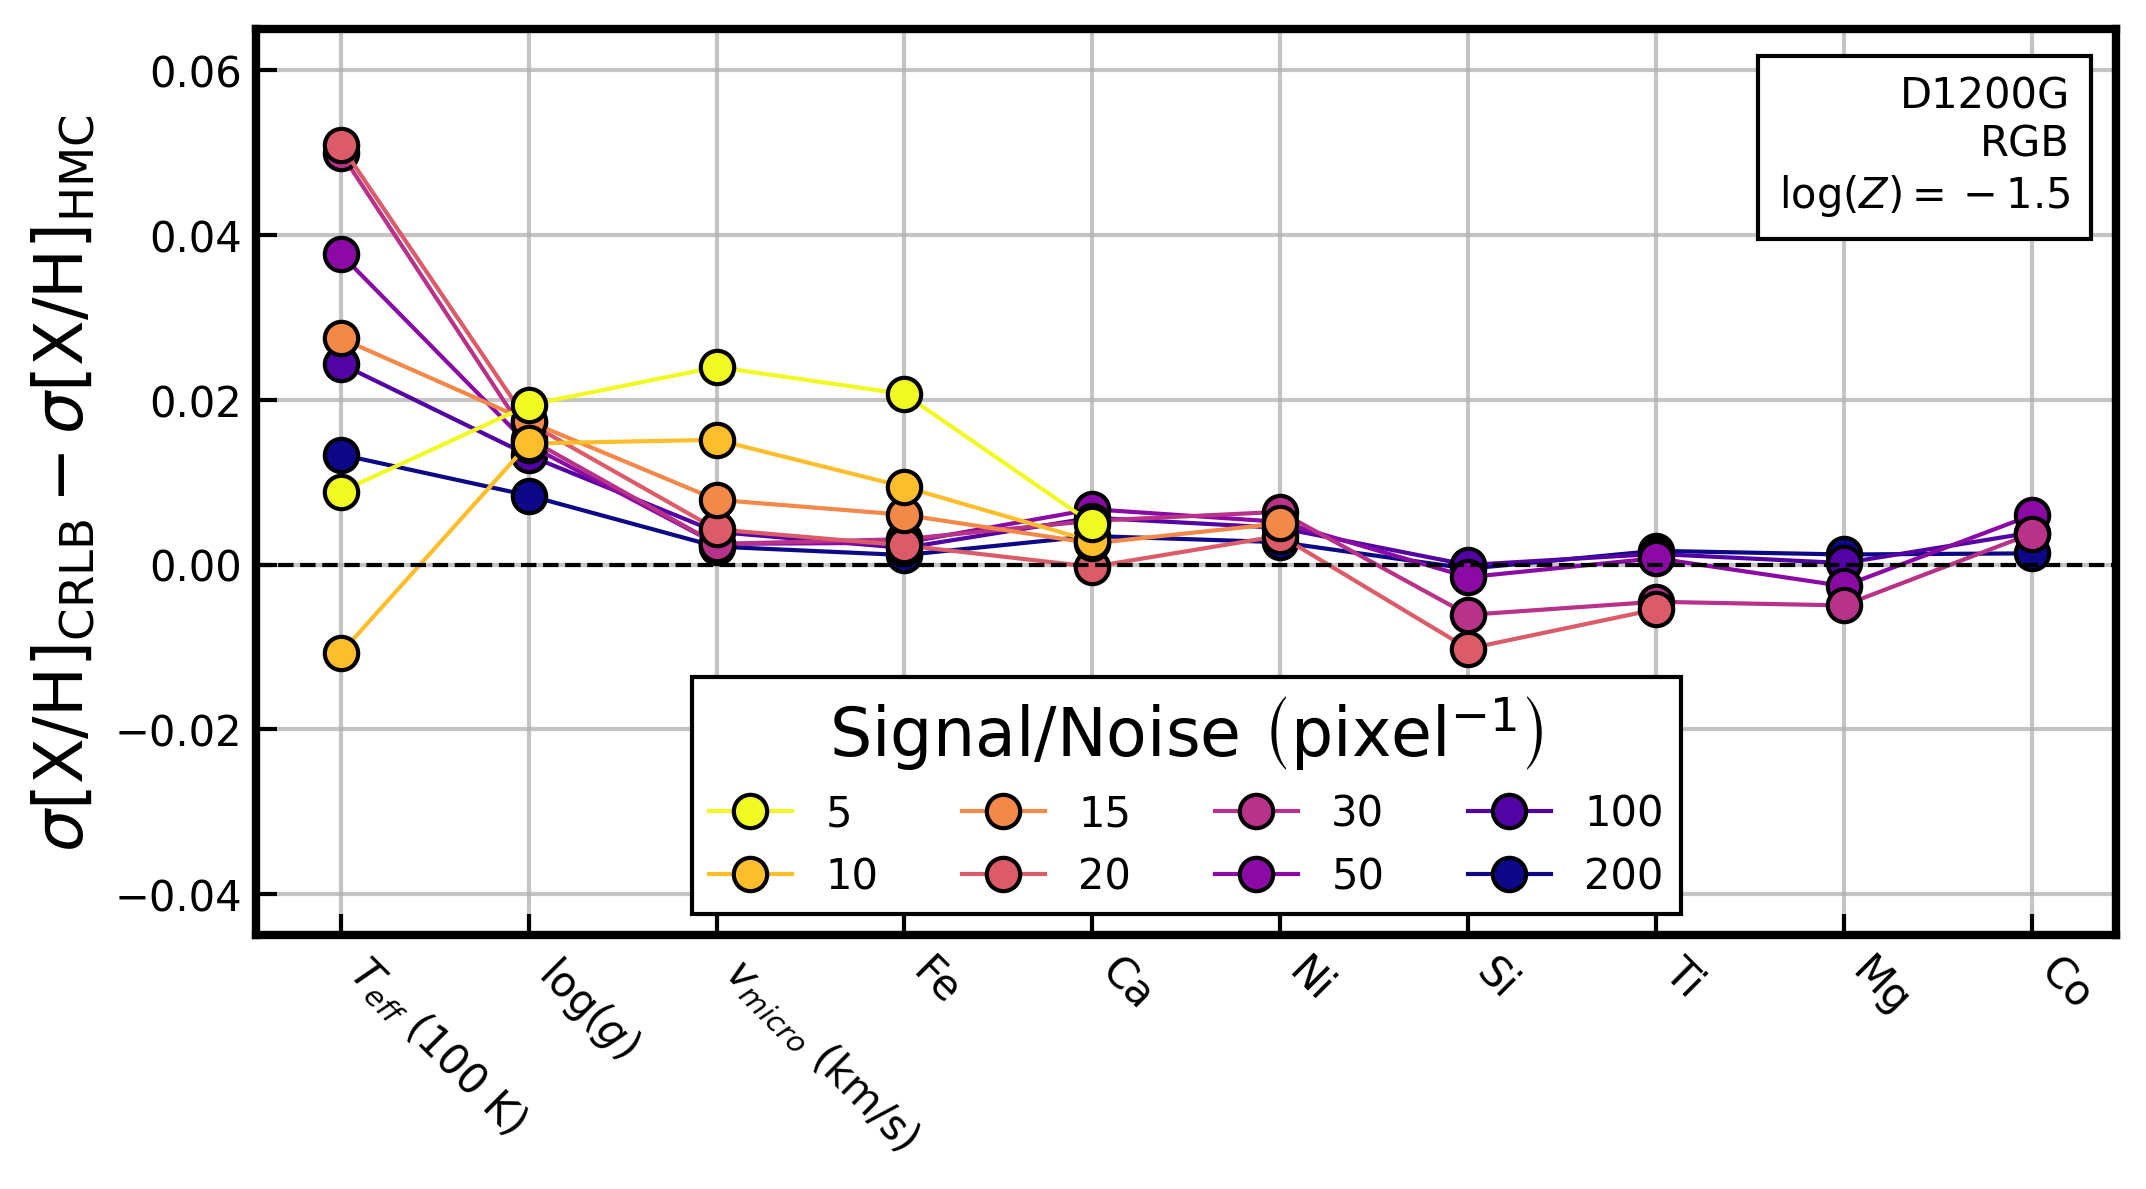

In [4]:
# Difference
crlb_diff = (CRLB_NN-CRLB_hmc).loc[CRLB_NN.index]

# Initialize Figure
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])
c = plt.cm.get_cmap('plasma', len(crlb_diff.columns))
# Plot CRLB - HMC Std
for j, col in enumerate(crlb_diff):
    mask = np.isfinite(crlb_diff.loc[:,col].values)
    plt.plot(crlb_diff.loc[:, col].index[mask],
             crlb_diff.loc[:, col].values[mask],
             marker='o', markersize=8, markeredgewidth=1,
             linestyle='-', linewidth=1,
             color=c(j), markeredgecolor='k',
             label=col)
# Annotations
ax.axhline(0.0, ls='--', lw=1, c='k')
ax.text(0.975, 0.95, s='D1200G\nRGB\n$\log(Z)=-1.5$', fontsize=10,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='black', pad=5.0))
#Axes
ax.set_ylabel(r'$\sigma\mathrm{[X/H]}_\mathrm{CRLB}-\sigma\mathrm{[X/H]}_\mathrm{HMC}$', size=16)
ax.set_ylim(-0.045, 0.065)
ax.tick_params(axis='x', which='major', rotation=-45)
for label in ax.get_xticklabels():
    label.set_horizontalalignment('left')
# Legend
legend = plt.legend()
handles, labels = fig.axes[0].get_legend_handles_labels()
legend = fig.axes[0].legend(handles[::-1], labels[::-1], fontsize=10,
                            ncol=4, loc='lower center', edgecolor='k',
                            title=r'Signal/Noise $\left(\mathrm{pixel}^{-1}\right)$')
legend.get_title().set_fontsize('16')
fig.savefig(output_dir+'crlb_validation.png')

# Appendix C

## Figure 21: DESI CRLBs

In [5]:
# Initialize Preset Instrument
allInst = inst.AllInstruments()
desi_b = allInst.get_spectrograph('DESI (b)')
desi_r = allInst.get_spectrograph('DESI (r)')
desi_i = allInst.get_spectrograph('DESI (i)')

# Initialize Reference Spectra
RGB_m15 = ref.ReferenceSpectra(reference='RGB_m1.5')
TRGB_m15 = ref.ReferenceSpectra(reference='TRGB_m1.5')
MSTO_m15 = ref.ReferenceSpectra(reference='MSTO_m1.5')

# Convolve Reference Spectra to Instrument Resolution
RGB_m15.convolve(desi_b)
RGB_m15.convolve(desi_r)
RGB_m15.convolve(desi_i)
TRGB_m15.convolve(desi_b)
TRGB_m15.convolve(desi_r)
TRGB_m15.convolve(desi_i)
MSTO_m15.convolve(desi_b)
MSTO_m15.convolve(desi_r)
MSTO_m15.convolve(desi_i)

# Calculate Gradient Spectra
RGB_m15.calc_gradient(desi_b.name)
RGB_m15.calc_gradient(desi_r.name)
RGB_m15.calc_gradient(desi_i.name)
TRGB_m15.calc_gradient(desi_b.name)
TRGB_m15.calc_gradient(desi_r.name)
TRGB_m15.calc_gradient(desi_i.name)
MSTO_m15.calc_gradient(desi_b.name)
MSTO_m15.calc_gradient(desi_r.name)
MSTO_m15.calc_gradient(desi_i.name)

# Initialize CRLB Data Frames
CRLB_desi = init_crlb_df(RGB_m15)

# Query S/N & Calculate CRLBs
desi_b.set_snr(30)
desi_r.set_snr(30)
desi_i.set_snr(30)
CRLB_desi['TRGB'] = calc_crlb(TRGB_m15, [desi_b, desi_r, desi_i])
CRLB_desi['RGB'] = calc_crlb(RGB_m15, [desi_b, desi_r, desi_i])
CRLB_desi['MSTO'] = calc_crlb(MSTO_m15, [desi_b, desi_r, desi_i])

# Sort CRLBs & Pretty Up Indices
CRLB_desi = sort_crlb(CRLB_desi, cutoff=0.3, fancy_labels=True)

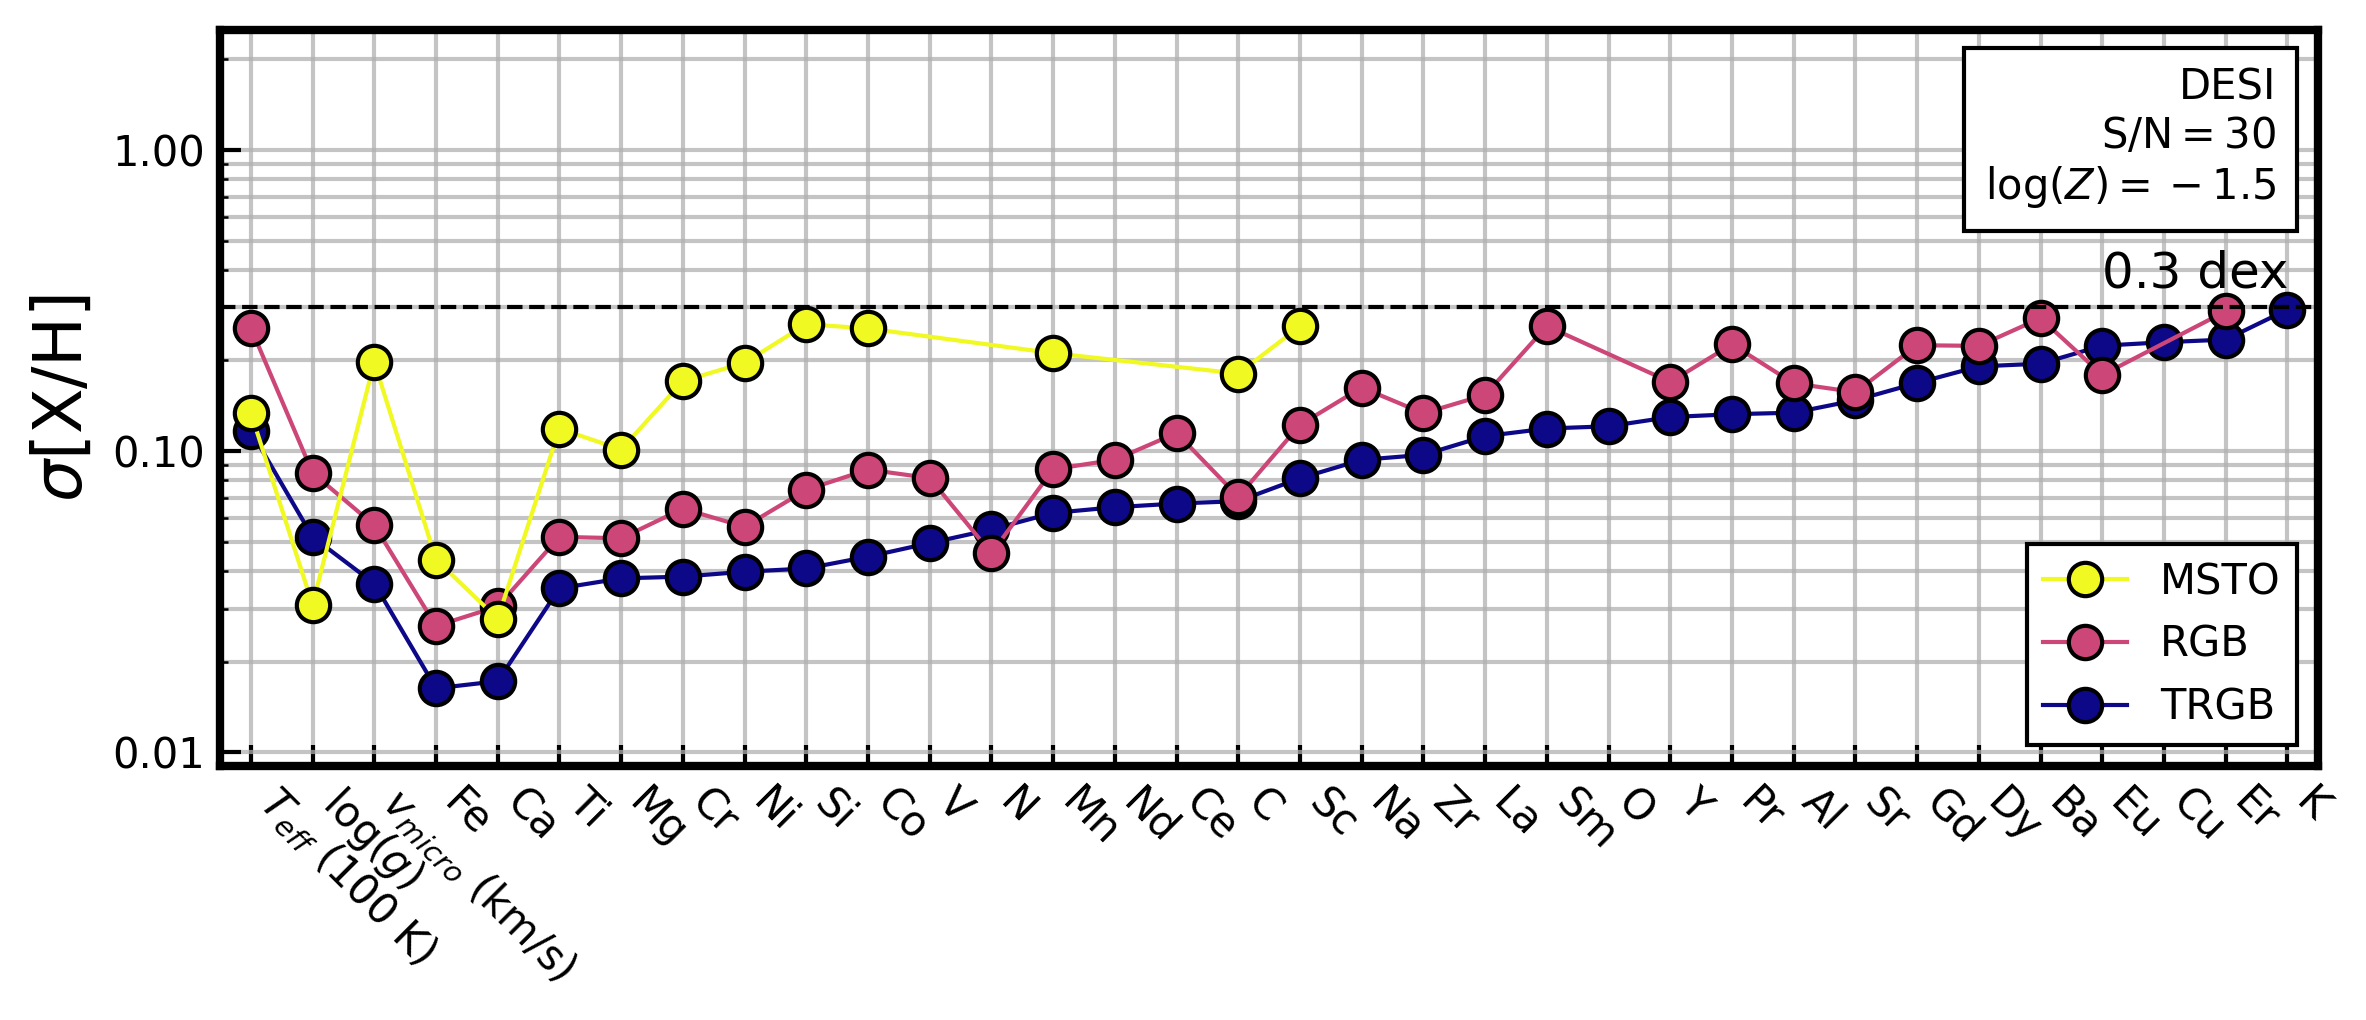

In [6]:
fig = plot_crlb([CRLB_desi],
                labels=['DESI\n$\mathrm{S/N}=30$\n$\log(Z)=-1.5$'],
                panel_height=3.5, cutoff_label_xoffset=4,
                ylim=(0.009, 2.5), legend_ncol=1, reverse_legend=True)
fig.savefig(output_dir+'crlb_desi.png')